In [8]:
# Load Data
import pandas as pd
treated = pd.read_csv('treated.csv', index_col=0)
controls = pd.read_csv('control.csv', index_col=0)

In [9]:
len(treated.pidp.unique())

797

In [10]:
len(controls.pidp.unique())

15145

In [11]:
controls.log_wage_h_deflated.min()

-7.796958198111132

In [12]:
treated[treated.years_treated<4]

,pidp,hidp,sex,jbnssec_dv,jbnssec8_dv,jbstat,jbhrs,ethn_dv,dvage,mastat_dv,...,unemployed_bool,control,treated,ever_treated,year_reindex,year_treated,year_treat_reindex,initial_year,reindex,years_treated
46,68150967,68150963,male,12.1 Semi-routine sales operations,Semi-routine,Paid employment(ft/pt),36.5,british/english/scottish/welsh/northern irish,47,Married,...,False,True,False,True,1,2016.0,8,2009.0,-7,3
13200,68150967,68856802,male,12.1 Semi-routine sales operations,Semi-routine,Paid employment(ft/pt),36.5,british/english/scottish/welsh/northern irish,48,Married,...,False,True,False,True,2,2016.0,8,2009.0,-6,3
26069,68150967,68904404,male,10 Lower supervisory occupations,Lower supervisory & technical,Paid employment(ft/pt),36.5,british/english/scottish/welsh/northern irish,49,Married,...,False,True,False,True,3,2016.0,8,2009.0,-5,3
36938,68150967,68836406,male,10 Lower supervisory occupations,Lower supervisory & technical,Paid employment(ft/pt),36.5,british/english/scottish/welsh/northern irish,50,Married,...,False,True,False,True,4,2016.0,8,2009.0,-4,3
46693,68150967,68673208,male,10 Lower supervisory occupations,Lower supervisory & technical,Paid employment(ft/pt),36.5,british/english/scottish/welsh/northern irish,51,Married,...,False,True,False,True,5,2016.0,8,2009.0,-3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87963,1643975050,1637045616,female,12.2 Semi-routine service operations,Semi-routine,Paid employment(ft/pt),15.0,pakistani,37,Married,...,False,True,False,True,3,2020.0,5,2016.0,-2,2
94730,1643975050,1636855218,female,12.2 Semi-routine service operations,Semi-routine,Paid employment(ft/pt),15.0,pakistani,38,Married,...,False,True,False,True,4,2020.0,5,2016.0,-1,2
101199,1643975050,1636658020,female,12.2 Semi-routine service operations,Semi-routine,Paid employment(ft/pt),15.0,pakistani,38,Married,...,False,False,True,True,5,2020.0,5,2016.0,0,2
107350,1643975050,1636494822,female,12.2 Semi-routine service operations,Semi-routine,Paid employment(ft/pt),15.0,pakistani,39,Married,...,False,False,True,True,6,2020.0,5,2016.0,1,2


In [13]:
treated[treated.pidp==1088956767][['year', 'years_treated', 'year_reindex', 'year_treat_reindex', 'year_treated', 'aidhrs_recoded_3', 'employed', 'wage_h_deflated']]

,year,years_treated,year_reindex,year_treat_reindex,year_treated,aidhrs_recoded_3,employed,wage_h_deflated
8941,2010.0,3,1,6,2015.0,NaN,employed,14.367002
22844,2011.0,3,2,6,2015.0,NaN,employed,14.301820
34193,2012.0,3,3,6,2015.0,NaN,employed,12.843777
44239,2013.0,3,4,6,2015.0,NaN,employed,13.615916
53461,2014.0,3,5,6,2015.0,NaN,employed,9.274975
61878,2015.0,3,6,6,2015.0,0-19,employed,12.413794
70695,2016.0,3,7,6,2015.0,NaN,employed,11.560047
78688,2017.0,3,8,6,2015.0,NaN,employed,11.603128
86017,2018.0,3,9,6,2015.0,NaN,employed,11.565415
92836,2019.0,3,10,6,2015.0,0-19,employed,10.929585


In [14]:
controls[controls.pidp==1088956767]

,pidp,hidp,sex,jbnssec_dv,jbnssec8_dv,jbstat,jbhrs,ethn_dv,dvage,mastat_dv,...,unemployed_bool,control,treated,ever_treated,year_reindex,year_treated,year_treat_reindex,initial_year,reindex,years_treated


In [25]:
def get_control_clean(c_data, t_data):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        treat_time = t_data[t_data.pidp == t_id].year_treated.unique()[0]
        treat = t_data[t_data.pidp == t_id].pivot_table(index='year', columns='pidp', values='log_wage_h_deflated')
        control = c_data.pivot_table(index='year', columns='pidp', values='log_wage_h_deflated')
        sub_sample = pd.concat([treat, control], axis=1, join="inner") # concat-join-inner ensure using index (year) as key
        out['data'] = sub_sample.dropna(axis=1) # only complete columns
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [26]:
def is_consecutive(l):
    return sorted(l) == list(range(min(l), max(l)+1))
idx = []
for pidp in treated.pidp:
    idx.append(is_consecutive(treated[treated.pidp == pidp].wave))

In [27]:
samples = get_control_clean(controls, treated)

In [28]:
from typing import List
from operator import add
from toolz import reduce, partial
import numpy as np
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from multiprocessing import Pool
import matplotlib.pyplot as plt

def create_index(x):
    y = np.arange(len(x)) + 1
    return y - x

def create_relative_index(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]

def create_relative_MultiIndex(lst, point):
    index = lst.index(point)
    return [i - index for i in range(len(lst))]


# the expression to minimise, since \mu is 0, we are one looking for \omega/W
def argmin_w(W, Y_i, Y_0):
    return np.sqrt(np.sum((Y_0 - Y_i.dot(W))**2))


# a function wrapping the whole process
def get_w(Y_i, Y_0):
    w_start = [1/Y_i.shape[1]]*Y_i.shape[1]
    weights = minimize(partial(argmin_w, Y_i=Y_i, Y_0=Y_0),
                       np.array(w_start),
                       method='SLSQP',
                       constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}), # constraint to sum to 1
                       bounds=[(0.0, 1.0)]*len(w_start),
                       )
    return weights.x

def sc(x, k_n=250):
    data = x['data'].copy()
    t_time = x['treat_time']
    data.sort_index(inplace=True)
    data.index = data.index - t_time # 
    df_T0 = data.loc[:-1, :] # this needs to be revised
    Y_0 = df_T0.iloc[:, 0].values
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0]
    diff = treated - synth
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff
    }


def isc(data_objects: list) -> dict:
    synths = []
    treats = []
    diffs = []
    std_diffs = []
    with Pool() as p:
        out = p.map(sc, data_objects)
    for ele in out:
        synths.append(ele['synth'])
        treats.append(ele['treated'])
        diffs.append(ele['diff'])
    return {'synths': synths,
            'treats': treats,
            'diffs': diffs}


In [29]:
# use cluster instead of nearest nieghtbours

In [30]:
samples[1]['data']

pidp,68150967,68035367,68042167,68044207,68045567,68060527,68105407,68163887,68167967,68167971,...,817077807,817255287,817271607,817271611,817917611,818586727,818586731,818637051,818645207,818715927
year,,,,,,,,,,,,,,,,,,,,,
2009.0,2.291935,2.844954,3.045583,2.456794,2.864763,3.004760,2.869218,2.769828,2.158293,2.097914,...,3.241023,2.158646,1.953109,2.780031,2.340970,2.927962,2.694245,2.684053,2.380668,2.015551
2010.0,2.726645,2.893653,3.178720,2.342095,2.864094,3.087558,2.784532,2.840712,2.292798,2.365164,...,3.329521,2.157442,2.018173,2.851557,2.835201,2.900174,4.356117,2.691327,2.456027,2.053573
2011.0,2.480478,2.866907,3.227051,2.393050,2.819695,3.203025,1.835531,2.728238,2.140919,2.500606,...,3.095619,2.192127,1.820317,2.328936,3.036745,3.038848,2.671020,2.852301,2.522891,2.088082
2012.0,2.297432,2.933377,3.222280,2.367380,2.788675,2.953080,2.758010,2.566281,2.345219,2.151847,...,3.060060,2.171293,1.837754,2.675134,2.513281,2.948818,2.567662,2.700058,2.454442,1.929705
2013.0,2.345338,3.412757,3.161013,2.407235,2.536312,3.031389,2.899129,2.804377,2.248630,2.391731,...,3.030048,2.261104,1.945642,2.382992,2.767025,2.663938,2.668583,2.628837,2.672211,2.078776
2014.0,2.243760,3.475546,3.192013,2.364121,2.615345,3.093074,2.678640,2.167814,2.202169,2.410922,...,2.862970,2.304353,1.907192,2.349843,2.924087,3.000409,2.716905,2.839915,2.806830,1.959519
2015.0,2.269146,3.541030,3.193944,2.459942,2.915460,2.975717,2.590225,1.904822,2.234238,2.433223,...,2.949951,2.521421,1.913674,2.307838,3.051775,2.937465,2.681693,2.884170,2.825522,-0.473769
2016.0,2.011823,3.490823,2.993421,2.488983,2.925890,3.091876,2.838359,2.632050,2.373471,2.056801,...,3.154047,2.397351,1.978265,2.558766,3.129453,2.947174,2.684596,2.733997,2.669812,1.997833
2017.0,2.221145,3.504519,3.176193,2.548488,2.952556,3.071138,3.072139,2.667514,2.384655,2.332011,...,2.919540,2.349875,1.727635,2.488420,3.115692,2.905535,2.639756,2.764291,2.607321,1.891613


In [31]:
sc(samples[100])

{'synth': year
 -3.0    1.956113
 -2.0    2.019154
 -1.0    1.948820
  0.0    2.043555
  1.0    2.080960
  2.0    2.089150
  3.0    2.101557
  4.0    2.107148
  5.0    2.167732
  6.0    2.157900
  7.0    2.234542
 dtype: float64,
 'treated': year
 -3.0    1.956112
 -2.0    2.019155
 -1.0    1.948820
  0.0    2.133228
  1.0    2.120023
  2.0    2.099717
  3.0    2.088101
  4.0    1.865803
  5.0    2.543102
  6.0    2.525084
  7.0    1.858977
 Name: 207325282, dtype: float64,
 'diff': year
 -3.0   -9.012901e-07
 -2.0    1.123724e-06
 -1.0   -4.461228e-07
  0.0    8.967347e-02
  1.0    3.906313e-02
  2.0    1.056786e-02
  3.0   -1.345697e-02
  4.0   -2.413448e-01
  5.0    3.753703e-01
  6.0    3.671842e-01
  7.0   -3.755658e-01
 dtype: float64}

In [32]:
out = isc(samples)

<Axes: xlabel='year'>

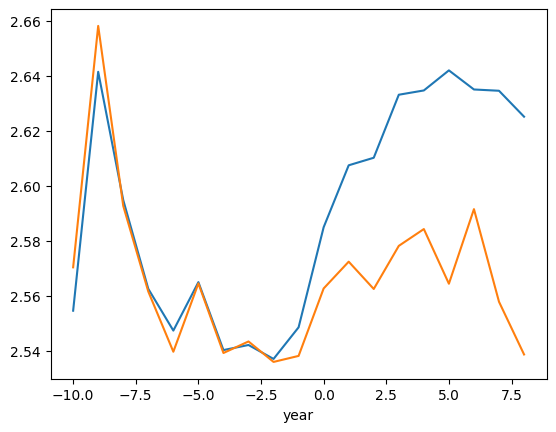

In [33]:
ss = pd.concat(out['synths'], axis=1).sort_index()
ts = pd.concat(out['treats'], axis=1).sort_index()
ss.mean(axis=1).plot()
ts.mean(axis=1).plot()

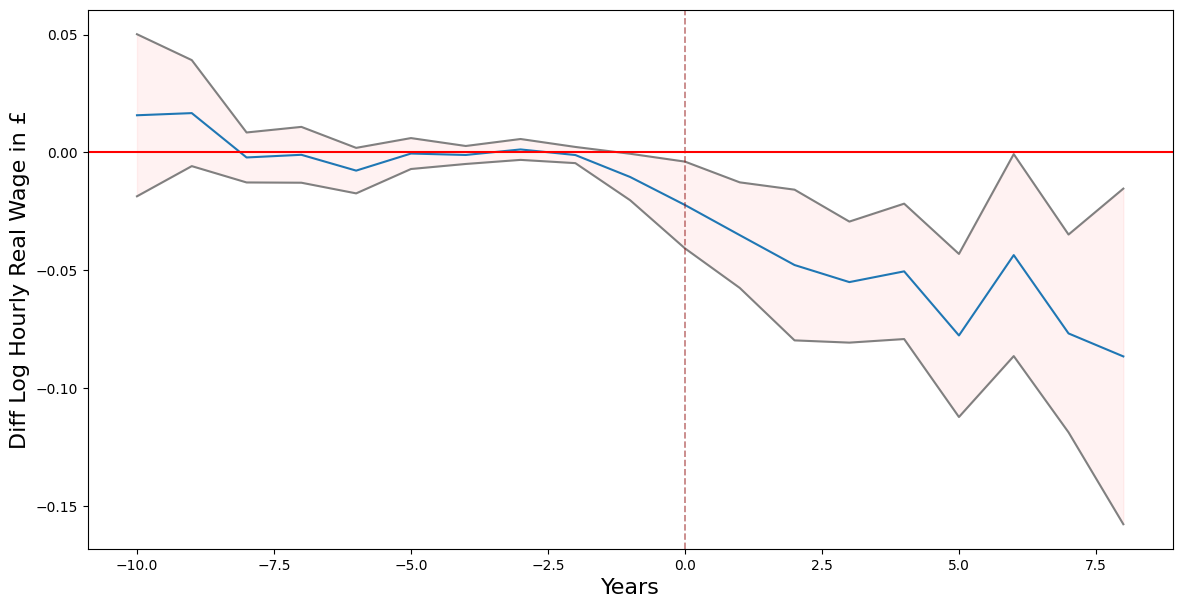

In [34]:
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.pyplot import figure

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()
differences.mean(axis=1).plot()
(differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
(differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt)))).plot(color='grey')
differences.count()
plt.axvline(x=0, linestyle='--', color='darkred', alpha=.5, linewidth=1.25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Diff Log Hourly Real Wage in £', fontsize=16)
plt.axhline(y=0, color='r', linestyle='-')
plt.fill_between(x=differences.index,
                 y1=differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                 y2=differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.05)
plt.show()

In [13]:
controls.pivot_table(index='wave', columns='pidp')[['wage_h_deflated']]

/tmp/ipykernel_5466/3413333499.py:1: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  controls.pivot_table(index='wave', columns='pidp')[['wage_h_deflated']]


wage_h_deflated                                                         \
pidp      76165      469205     665045     1697285    1731965    2539125      
wave                                                                          
1                NaN        NaN        NaN        NaN        NaN        NaN   
2                NaN        NaN        NaN        NaN        NaN  11.947284   
3                NaN        NaN   6.430399        NaN        NaN        NaN   
4                NaN        NaN   5.301611        NaN        NaN        NaN   
5                NaN        NaN   7.109646        NaN  15.710672        NaN   
6                NaN        NaN   4.466682        NaN        NaN        NaN   
7          17.887452        NaN        NaN        NaN        NaN        NaN   
8          23.002678        NaN   8.831088   8.417547        NaN        NaN   
9         125.160167   7.969182        NaN   9.995763        NaN        NaN   
10         25.000149   9.268407   3.685555   8.271766        NaN        NaN   
11         26.393929   9.729761   5.231720        NaN        NaN        NaN   
12         27.900765   9.968356   3.455697        NaN        NaN        NaN   

                                                  ...                        \
pidp 2853965    3667245    3914085    4192205     ... 1652508850 1652590450   
wave                                              ...                         
1           NaN        NaN        NaN        NaN  ...        NaN        NaN   
2      8.260502        NaN        NaN  10.218889  ...        NaN        NaN   
3     12.661542        NaN        NaN  11.910530  ...        NaN        NaN   
4     13.642532        NaN        NaN  10.221715  ...        NaN        NaN   
5     16.249198  16.617057        NaN        NaN  ...        NaN        NaN   
6     16.182464  16.350117        NaN        NaN  ...        NaN        NaN   
7     16.772804  11.680006        NaN        NaN  ...  28.238931   9.760195   
8           NaN  13.338498        NaN        NaN  ...  24.606894        NaN   
9           NaN  13.946068        NaN        NaN  ...        NaN        NaN   
10          NaN  15.901696        NaN        NaN  ...        NaN        NaN   
11          NaN  15.313014   9.950299        NaN  ...        NaN        NaN   
12          NaN        NaN        NaN        NaN  ...        NaN        NaN   

                                                                        \
pidp 1652835250 1652930450 1652964450 1653018850 1653059730 1653209250   
wave                                                                     
1           NaN        NaN        NaN        NaN        NaN        NaN   
2           NaN        NaN        NaN        NaN        NaN        NaN   
3           NaN        NaN        NaN        NaN        NaN        NaN   
4           NaN        NaN        NaN        NaN        NaN        NaN   
5           NaN        NaN        NaN        NaN        NaN        NaN   
6           NaN        NaN        NaN        NaN        NaN        NaN   
7     15.467955   6.819298  25.891134  22.686334  29.708274  12.153393   
8           NaN   7.168838        NaN        NaN        NaN        NaN   
9      9.488248        NaN        NaN        NaN        NaN        NaN   
10     9.971532        NaN        NaN        NaN        NaN        NaN   
11     9.176316        NaN        NaN        NaN        NaN        NaN   
12     8.888148        NaN        NaN        NaN        NaN        NaN   

                            
pidp 1653222850 1653222890  
wave                        
1           NaN        NaN  
2           NaN        NaN  
3           NaN        NaN  
4           NaN        NaN  
5           NaN        NaN  
6           NaN        NaN  
7     27.547692  15.692713  
8           NaN        NaN  
9           NaN        NaN  
10          NaN        NaN  
11          NaN        NaN  
12          NaN        NaN  

[12 rows x 15145 columns]

In [26]:
treated.pivot_table(index='year', columns='pidp', values='dvage')

pidp,68068011,68150967,68150971,68150975,68273371,68274727,68322327,68366531,68479411,68597727,...,1632638527,1632677971,1632681371,1632683407,1632756847,1632791531,1633102291,1633743527,1634125687,1638378484
year,,,,,,,,,,,,,,,,,,,,,
2009.0,42.0,47.0,NaN,20.0,42.0,42.0,42.0,NaN,41.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010.0,43.0,48.0,51.0,21.0,43.0,43.0,43.0,59.0,42.0,50.0,...,44.0,23.0,38.0,47.0,39.0,38.0,30.0,41.0,47.0,NaN
2011.0,44.0,49.0,52.0,22.0,44.0,44.0,44.0,60.0,43.0,52.0,...,45.0,24.0,39.0,48.0,40.0,40.0,31.0,41.0,48.0,NaN
2012.0,45.0,50.0,53.0,24.0,45.0,45.0,45.0,61.0,44.0,53.0,...,46.0,25.0,40.0,49.0,41.0,40.0,32.0,42.0,49.0,45.0
2013.0,46.0,51.0,53.0,24.0,46.0,46.0,46.0,62.0,45.0,54.0,...,47.0,26.0,41.0,51.0,42.0,42.0,33.0,43.0,50.0,46.0
2014.0,47.0,52.0,55.0,25.0,47.0,48.0,47.0,NaN,46.0,55.0,...,48.0,27.0,42.0,51.0,43.0,42.0,34.0,44.0,51.0,47.0
2015.0,48.0,53.0,56.0,26.0,48.0,49.0,49.0,64.0,47.0,56.0,...,49.0,28.0,43.0,52.0,44.0,NaN,35.0,45.0,52.0,48.0
2016.0,49.0,54.0,57.0,27.0,49.0,50.0,49.0,NaN,48.0,56.0,...,50.0,29.0,44.0,53.0,45.0,44.0,36.0,46.0,53.0,49.0
2017.0,50.0,55.0,58.0,29.0,50.0,NaN,50.0,NaN,49.0,57.0,...,51.0,30.0,45.0,54.0,45.0,NaN,37.0,47.0,NaN,50.0


In [42]:
controls[controls.pidp==1020477375][['month', 'year', 'wave', 'month_recoded']]

,month,year,wave,month_recoded
7789,mar yr2,2010.0,1,15.0
20872,mar yr2,2011.0,2,15.0
31401,mar yr2,2012.0,3,15.0
40654,mar yr2,2013.0,4,15.0
49093,mar yr2,2014.0,5,15.0
56739,jan yr2,2015.0,6,13.0
64846,jan yr2,2016.0,7,13.0
72171,aug yr1,2016.0,8,8.0
78877,sep yr1,2017.0,9,9.0
85104,sep yr1,2018.0,10,9.0


In [5]:
def get_control_clean(c_data, t_data, features):
    samples = []
    t_ids = t_data.pidp.unique().tolist()
    for t_id in t_ids:
        out = {}
        treat_time = t_data[t_data.pidp == t_id].year_treated.unique()[0]
        treat = t_data[t_data.pidp == t_id].pivot_table(index='year', columns='pidp')[features].T
        control = c_data.pivot_table(index='year', columns='pidp')[features].T
        sub_sample = pd.concat([treat, control], axis=1, join="inner") # concat-join-inner ensure using index (year) as key
        out['data'] = sub_sample.dropna(axis=1) # only complete columns
        out['treat_time'] = treat_time
        samples.append(out)
    return samples

In [6]:
new_samples = get_control_clean(controls, treated, ['wage_h_deflated', 'dvage'])

/tmp/ipykernel_5466/4175608948.py:7: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  treat = t_data[t_data.pidp == t_id].pivot_table(index='year', columns='pidp')[features].T
/tmp/ipykernel_5466/4175608948.py:8: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  control = c_data.pivot_table(index='year', columns='pidp')[features].T


KeyError: "['dvage'] not in index"

In [50]:
new_samples[0]['data']

pidp                 68068011   68035367   68042167   68044207   68045567    \
                wave                                                          
wage_h_deflated 1     19.612539  17.200761  21.022278  11.667351  17.544889   
                2     19.585289  18.059163  24.015987  10.403013  17.533167   
                3     19.371906  17.582557  25.205208  10.946832  16.771742   
                4     18.949522  18.790988  25.085248  10.669405  16.259468   
                5     18.333412  30.348789  23.594483  11.103215  12.632992   
                6     17.643905  32.315474  24.337381  10.634685  13.671931   
                7     17.546066  34.502454  24.384411  11.704135  18.457293   
                8     17.036082  32.812946  19.953831  12.049022   18.65082   
                9     17.240966  33.265448  23.955375  12.787756   19.15485   
                10     18.04848  32.510647  23.390415  11.532143  19.113669   
                11    16.535335  31.417872  23.377557  17.569695  18.741008   
                12    17.877472  32.738032  24.426964  12.452981  18.851066   
dvage           1            42         28         39         33         47   
                2            43         29         40         34         48   
                3            44         30         41         35         49   
                4            45         31         42         36         50   
                5            46         32         43         37         51   
                6            47         33         44         38         52   
                7            48         34         45         39         53   
                8            49         35         46         40         54   
                9            50         36         47         42         55   
                10           51         37         48         42         56   
                11           52         38         49         43         57   
                12           53         39         50         44         58   

pidp                 68060527   68105407   68163887   68167967   68167971    \
                wave                                                          
wage_h_deflated 1     20.181364  17.623234  15.955891   8.656346   8.149149   
                2     21.923473  16.192231  17.127955   9.902604   10.64578   
                3     24.606865   6.268459  15.305887   8.507252  12.189879   
                4     19.164899  15.768432  13.017326  10.435556   8.600733   
                5     20.726002   18.15833  16.516783   9.474744  10.932397   
                6     22.044729  14.565268   8.739161   9.044606  11.144234   
                7     19.603667  13.332777   6.718213   9.339359  11.395556   
                8     22.018349  17.087703  13.902243  10.734583    7.82091   
                9     21.566421  21.588024  14.404109  10.855318  10.298635   
                10    21.420884  18.311698  11.305467  13.956978  10.632626   
                11    22.208679  16.435968  33.917433  10.412654   13.32342   
                12    20.116323  18.607599  27.889296   10.92029   8.179164   
dvage           1            35         42         24         31         31   
                2            36         43         25         32         32   
                3            37         44         26         33         33   
                4            38         45         27         34         34   
                5            39         46         28         35         35   
                6            40         47         29         36         36   
                7            41         48         30         37         37   
                8            42         49         31         38         38   
                9            43         50         32         39         39   
                10           44         51         33         40         40   
                11           45         52       

In [73]:
example = new_samples[0]['data'].copy()
t_time = new_samples[0]['treat_time']
#example.sort_index(inplace=True)
example.index = create_relative_multiIndex(example.index.get_level_values('wave').tolist(), t_time)
#df_T0 = example.loc[:-1, :] # this needs to be revised
#df_T0
example

pidp,68068011,68035367,68042167,68044207,68045567,68060527,68105407,68163887,68167967,68167971,...,1633235567,1633244407,1633271607,1633314447,1633326687,1633326691,1633351851,1633780927,1634234487,1634453447
-7,19.612539,17.200761,21.022278,11.667351,17.544889,20.181364,17.623234,15.955891,8.656346,8.149149,...,10.482361,8.268015,12.458984,19.567054,25.157612,18.688512,32.380775,7.120079,22.736997,23.655916
-6,19.585289,18.059163,24.015987,10.403013,17.533167,21.923473,16.192231,17.127955,9.902604,10.64578,...,10.16136,7.816414,10.534443,19.718293,19.858157,14.225889,33.3397,8.086375,20.258479,54.063196
-5,19.371906,17.582557,25.205208,10.946832,16.771742,24.606865,6.268459,15.305887,8.507252,12.189879,...,10.070898,8.339517,11.054159,20.105362,23.7327,19.211874,28.482658,6.117593,20.726002,50.861889
-4,18.949522,18.790988,25.085248,10.669405,16.259468,19.164899,15.768432,13.017326,10.435556,8.600733,...,9.843117,9.438217,10.863763,19.659477,15.116386,10.534878,30.084266,6.149767,23.457464,46.263417
-3,18.333412,30.348789,23.594483,11.103215,12.632992,20.726002,18.15833,16.516783,9.474744,10.932397,...,8.102014,9.528285,10.809006,20.320425,19.815262,12.667291,30.823763,7.275292,24.250975,55.040194
-2,17.643905,32.315474,24.337381,10.634685,13.671931,22.044729,14.565268,8.739161,9.044606,11.144234,...,9.868837,9.089057,10.679815,19.995926,18.741727,12.866816,30.736429,10.590836,23.025611,49.439178
-1,17.546066,34.502454,24.384411,11.704135,18.457293,19.603667,13.332777,6.718213,9.339359,11.395556,...,10.730023,9.514755,10.491716,25.600012,18.473158,14.243723,29.593547,4.201173,22.686334,53.80152
0,17.036082,32.812946,19.953831,12.049022,18.65082,22.018349,17.087703,13.902243,10.734583,7.82091,...,10.662348,9.886147,10.94483,24.255884,19.069298,14.168335,29.228116,7.942618,23.941844,52.366813
1,17.240966,33.265448,23.955375,12.787756,19.15485,21.566421,21.588024,14.404109,10.855318,10.298635,...,10.241539,7.201337,10.240622,24.04947,18.604743,13.061179,20.128278,12.166985,22.525268,51.677776
2,18.04848,32.510647,23.390415,11.532143,19.113669,21.420884,18.311698,11.305467,13.956978,10.632626,...,11.277076,8.587528,10.663293,23.360833,16.810058,13.031783,25.89621,9.625749,25.370945,50.677561


In [ ]:
Y_0 = df_T0.iloc[:, 0].values
kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
idx = kdt.query(df_T0.T, k=100, return_distance=False)[0, 1:]
Y_i = df_T0.iloc[:, idx].values
weights = get_w(Y_i, Y_0)
synth = data.iloc[:, idx].dot(weights) # synthetic control is now based on the new subset of observations
treated = data.iloc[:, 0]

In [30]:
treated

,Unnamed: 0,pidp,carer,wage_deflated,wage_h_deflated,wave,date,employed,dvage,waves_caring,wave_reindex,wave_treat,wave_treat_real,initial_wave,reindex,ever_carer
201,17,68068011,False,3142.124802,19.612539,1,2009-01-01,employed,42,5,1,8,8,1,-7,True
202,6813,68068011,False,3137.759097,19.585289,2,2010-01-01,employed,43,5,2,8,8,1,-6,True
203,15809,68068011,False,3103.573070,19.371906,3,2011-01-01,employed,44,5,3,8,8,1,-5,True
204,24841,68068011,False,3035.902851,18.949522,4,2012-01-01,employed,45,5,4,8,8,1,-4,True
205,33934,68068011,False,2937.195957,18.333412,5,2013-01-01,employed,46,5,5,8,8,1,-3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85993,70374,1633102291,False,1722.488038,18.943012,8,2018-01-01,employed,37,3,8,10,10,1,-2,True
85994,78582,1633102291,False,1638.576779,18.020200,9,2019-02-01,employed,38,3,9,10,10,1,-1,True
85995,86341,1633102291,True,1569.713758,17.262881,10,2020-01-01,employed,39,3,10,10,10,1,0,True
85996,93577,1633102291,True,1715.462031,18.865743,11,2021-01-01,employed,40,3,11,10,10,1,1,True


In [129]:
out = {}
init = 2
treat_time = 6
last_wave = 9
length = (last_wave + 1) - init
# HUGE PROBLEM HERE waves need to match exactly!!! do not use range!!!
idx = controls[(controls.wave >= init) & (controls.wave <= last_wave)].groupby('pidp')['pidp'].transform('count') == length
idx
sub_sample = controls[(controls.wave >= init) & (controls.wave <= last_wave)][idx].reset_index(drop=True)
t = treated[treated.pidp == 68068011].pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T
s = sub_sample.pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T
sub_sample = pd.concat([t, s], axis=1, join="inner").dropna(axis=1)

In [128]:
controls.pivot(index='pidp', columns='wave')[['wage_h_deflated', 'dvage']].T.loc[(slice(None), slice(2,9)), :].dropna(axis=1)

pidp                 68035367   68042167   68044207   68045567   68046927    \
                wave                                                          
wage_h_deflated 2     18.059163  24.015987  10.403013  17.533167   9.074767   
                3     17.582557  25.205208  10.946832  16.771742   9.859596   
                4     18.790988  25.085248  10.669405  16.259468   9.612679   
                5     30.348789  23.594483  11.103215  12.632992   9.519157   
                6     32.315474  24.337381  10.634685  13.671931  11.531376   
                7     34.502454  24.384411  11.704135  18.457293  10.591423   
                8     32.812946  19.953831  12.049022   18.65082  11.889509   
                9     33.265448  23.955375  12.787756   19.15485   11.97953   
dvage           2            29         40         34         48         37   
                3            30         41         35         49         38   
                4            31         42         36         50         39   
                5            32         43         37         51         40   
                6            33         44         38         52         41   
                7            34         45         39         53         42   
                8            35         46         40         54         43   
                9            36         47         42         55         44   

pidp                 68060527   68105407   68120371   68163887   68166607    \
                wave                                                          
wage_h_deflated 2     21.923473  16.192231  10.330712  17.127955  13.325207   
                3     24.606865   6.268459  13.671401  15.305887  14.815262   
                4     19.164899  15.768432   7.678013  13.017326  14.651976   
                5     20.726002   18.15833  16.356753  16.516783  13.942203   
                6     22.044729  14.565268  13.289995   8.739161   8.062558   
                7     19.603667  13.332777  11.521258   6.718213   6.935342   
                8     22.018349  17.087703  18.970884  13.902243    7.89145   
                9     21.566421  21.588024  11.206224  14.404109   9.233259   
dvage           2            36         43         59         25         54   
                3            37         44         60         26         55   
                4            38         45         61         27         57   
                5            39         46         62         28         57   
                6            40         47         63         29         59   
                7            41         48         64         30         60   
                8            42         49         65         31         61   
                9            43         50         66         32         62   

pidp                  ... 1633272971 1633314447 1633326687 1633326691  \
                wave  ...                                               
wage_h_deflated 2     ...  14.698238  19.718293  19.858157  14.225889   
                3     ...  19.727421  20.105362    23.7327  19.211874   
                4     ...  17.196432  19.659477  15.116386  10.534878   
                5     ...  19.505649  20.320425  19.815262  12.667291   
                6     ...  18.694338  19.995926  18.741727  12.866816   
                7     ...  18.933076  25.600012  18.473158  14.243723   
                8     ...  22.697482  24.255884  19.069298  14.168335   
                9     ...  22.793118   24.04947  18.604743  13.061179   
dvage           2     ...         31         28         45         45   
                3     ...         32         29         46         46   
                4     ...         33         30         47         48   
                5     ...         34         31         48         48   
                6     ...         35         32         49         49   
                7     ...         36         33         50 

In [130]:
sub_sample

pidp                 68068011   68035367   68042167   68044207   68045567    \
                wave                                                          
wage_h_deflated 2     19.585289  18.059163  24.015987  10.403013  17.533167   
                3     19.371906  17.582557  25.205208  10.946832  16.771742   
                4     18.949522  18.790988  25.085248  10.669405  16.259468   
                5     18.333412  30.348789  23.594483  11.103215  12.632992   
                6     17.643905  32.315474  24.337381  10.634685  13.671931   
                7     17.546066  34.502454  24.384411  11.704135  18.457293   
                8     17.036082  32.812946  19.953831  12.049022   18.65082   
                9     17.240966  33.265448  23.955375  12.787756   19.15485   
dvage           2            43         29         40         34         48   
                3            44         30         41         35         49   
                4            45         31         42         36         50   
                5            46         32         43         37         51   
                6            47         33         44         38         52   
                7            48         34         45         39         53   
                8            49         35         46         40         54   
                9            50         36         47         42         55   

pidp                 68046927   68060527   68105407   68120371   68163887    \
                wave                                                          
wage_h_deflated 2      9.074767  21.923473  16.192231  10.330712  17.127955   
                3      9.859596  24.606865   6.268459  13.671401  15.305887   
                4      9.612679  19.164899  15.768432   7.678013  13.017326   
                5      9.519157  20.726002   18.15833  16.356753  16.516783   
                6     11.531376  22.044729  14.565268  13.289995   8.739161   
                7     10.591423  19.603667  13.332777  11.521258   6.718213   
                8     11.889509  22.018349  17.087703  18.970884  13.902243   
                9      11.97953  21.566421  21.588024  11.206224  14.404109   
dvage           2            37         36         43         59         25   
                3            38         37         44         60         26   
                4            39         38         45         61         27   
                5            40         39         46         62         28   
                6            41         40         47         63         29   
                7            42         41         48         64         30   
                8            43         42         49         65         31   
                9            44         43         50         66         32   

pidp                  ... 1633272971 1633314447 1633326687 1633326691  \
                wave  ...                                               
wage_h_deflated 2     ...  14.698238  19.718293  19.858157  14.225889   
                3     ...  19.727421  20.105362    23.7327  19.211874   
                4     ...  17.196432  19.659477  15.116386  10.534878   
                5     ...  19.505649  20.320425  19.815262  12.667291   
                6     ...  18.694338  19.995926  18.741727  12.866816   
                7     ...  18.933076  25.600012  18.473158  14.243723   
                8     ...  22.697482  24.255884  19.069298  14.168335   
                9     ...  22.793118   24.04947  18.604743  13.061179   
dvage           2     ...         31         28         45         45   
                3     ...         32         29         46         46   
                4     ...         33         30         47         48   
                5     ...         34         31         48         48   
                6     ...         35         32         49         49   
                7     ...         36         33         50 